# LightGBM - <br /> by Jerome, 30 November 2021 #

---

In [1]:
## load modules
import sys
sys.path.append("..")
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from modeling.functions import modelling, log_to_mlflow, get_features 
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler

RSEED = 42


/Users/jeromesauer/neuefische/Capstone_WindPowerPredicting/.venv/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


### Read data, remove NaNs and get dummies for cardinal wind directions ###

In [2]:
## read data
data = pd.read_csv('../data/GEFCom2014Data/Wind/raw_data_incl_features.csv', parse_dates=['TIMESTAMP'])
data.dropna(inplace=True)
data = pd.get_dummies(data, columns = ['WD100CARD','WD10CARD'])
data.info()
data.head()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 175265 entries, 0 to 175433
Data columns (total 49 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   ZONEID         175265 non-null  int64         
 1   TIMESTAMP      175265 non-null  datetime64[ns]
 2   TARGETVAR      175265 non-null  float64       
 3   U10            175265 non-null  float64       
 4   V10            175265 non-null  float64       
 5   U100           175265 non-null  float64       
 6   V100           175265 non-null  float64       
 7   HOUR           175265 non-null  int64         
 8   MONTH          175265 non-null  int64         
 9   WEEKDAY        175265 non-null  int64         
 10  IS_HOLIDAY     175265 non-null  int64         
 11  WS10           175265 non-null  float64       
 12  WS100          175265 non-null  float64       
 13  WD10           175265 non-null  float64       
 14  WD100          175265 non-null  float64       
 15  

,ZONEID,TIMESTAMP,TARGETVAR,U10,V10,U100,V100,HOUR,MONTH,WEEKDAY,...,WD10CARD_NNW,WD10CARD_NW,WD10CARD_S,WD10CARD_SE,WD10CARD_SSE,WD10CARD_SSW,WD10CARD_SW,WD10CARD_W,WD10CARD_WNW,WD10CARD_WSW
0,1,2012-01-01 01:00:00,0.000000,2.124600,-2.681966,2.864280,-3.666076,1,1,6,...,0,1,0,0,0,0,0,0,0,0
1,1,2012-01-01 02:00:00,0.054879,2.521695,-1.796960,3.344859,-2.464761,2,1,6,...,0,1,0,0,0,0,0,0,0,0
2,1,2012-01-01 03:00:00,0.110234,2.672210,-0.822516,3.508448,-1.214093,3,1,6,...,0,0,0,0,0,0,0,0,1,0
3,1,2012-01-01 04:00:00,0.165116,2.457504,-0.143642,3.215233,-0.355546,4,1,6,...,0,0,0,0,0,0,0,1,0,0
4,1,2012-01-01 05:00:00,0.156940,2.245898,0.389576,2.957678,0.332701,5,1,6,...,0,0,0,0,0,0,0,1,0,0


### Train-test-split, get different combinations of features and perform linear regression for different feature combinations ###

In [3]:
## train-test-split
data_train, data_test = train_test_split(data, test_size=0.25, random_state=RSEED, stratify=data.ZONEID)

In [4]:
## get features
feature_dict = get_features(data)
feature_dict['all']

['U10',
 'V10',
 'U100',
 'V100',
 'HOUR',
 'MONTH',
 'WEEKDAY',
 'IS_HOLIDAY',
 'WS10',
 'WS100',
 'WD10',
 'WD100',
 'U100NORM',
 'V100NORM',
 'WD100CARD_E',
 'WD100CARD_ENE',
 'WD100CARD_ESE',
 'WD100CARD_N',
 'WD100CARD_NE',
 'WD100CARD_NNE',
 'WD100CARD_NNW',
 'WD100CARD_NW',
 'WD100CARD_S',
 'WD100CARD_SE',
 'WD100CARD_SSE',
 'WD100CARD_SSW',
 'WD100CARD_SW',
 'WD100CARD_W',
 'WD100CARD_WNW',
 'WD100CARD_WSW',
 'WD10CARD_E',
 'WD10CARD_ENE',
 'WD10CARD_ESE',
 'WD10CARD_N',
 'WD10CARD_NE',
 'WD10CARD_NNE',
 'WD10CARD_NNW',
 'WD10CARD_NW',
 'WD10CARD_S',
 'WD10CARD_SE',
 'WD10CARD_SSE',
 'WD10CARD_SSW',
 'WD10CARD_SW',
 'WD10CARD_W',
 'WD10CARD_WNW',
 'WD10CARD_WSW']

In [5]:
results = {}

for key in feature_dict.keys(): 

    results[key] = {} 

    # linear regression
    results[key]['LR_train'], results[key]['LR_test'], _ \
        = modelling(data_train, data_test, feature_dict[key], LinearRegression(), scaler=None, print_scores=True, log=None, infotext_mlflow=None)
    results[key]['LR_train'] = {k : np.round(value,4) for k,value in results[key]['LR_train'].items()}
    results[key]['LR_test'] = {k : np.round(value,4) for k,value in results[key]['LR_test'].items()}

    # KNN
    results[key]['KNN_train'], results[key]['KNN_test'], _ \
        = modelling(data_train, data_test, feature_dict[key], KNeighborsRegressor(n_neighbors = 5, n_jobs = -1), \
                    scaler=MinMaxScaler(), print_scores=True, log=None, infotext_mlflow=None)
    results[key]['KNN_train'] = {k : np.round(value,4) for k,value in results[key]['KNN_train'].items()}
    results[key]['KNN_test'] = {k : np.round(value,4) for k,value in results[key]['KNN_test'].items()}

    # LGBM
    results[key]['LGBM_train'], results[key]['LGBM_test'], _ \
        = modelling(data_train, data_test, feature_dict[key], lgb.LGBMRegressor(), scaler=None, print_scores=True, log=None, infotext_mlflow=None)
    results[key]['LGBM_train'] = {k : np.round(value,4) for k,value in results[key]['LGBM_train'].items()}
    results[key]['LGBM_test'] = {k : np.round(value,4) for k,value in results[key]['LGBM_test'].items()}

train-RMSE/test-RMSE linear regression model for ZONE1: 0.181 0.183

train-RMSE/test-RMSE linear regression model for ZONE2: 0.154 0.149

train-RMSE/test-RMSE linear regression model for ZONE3: 0.152 0.154

train-RMSE/test-RMSE linear regression model for ZONE4: 0.177 0.179

train-RMSE/test-RMSE linear regression model for ZONE5: 0.18 0.183

train-RMSE/test-RMSE linear regression model for ZONE6: 0.188 0.185

train-RMSE/test-RMSE linear regression model for ZONE7: 0.138 0.139

train-RMSE/test-RMSE linear regression model for ZONE8: 0.17 0.17

train-RMSE/test-RMSE linear regression model for ZONE9: 0.165 0.164

train-RMSE/test-RMSE linear regression model for ZONE10: 0.203 0.205

train-RMSE/test-RMSE linear regression model for TOTAL: 0.172 0.172

Scaler: MinMaxScaler
Scaled X_train min/max: 0.0, 1.0
Scaled X_test min/max: -0.0, 1.02

Scaler: MinMaxScaler
Scaled X_train min/max: 0.0, 1.0
Scaled X_test min/max: 0.0, 1.0

Scaler: MinMaxScaler
Scaled X_train min/max: 0.0, 1.0
Scaled X_test

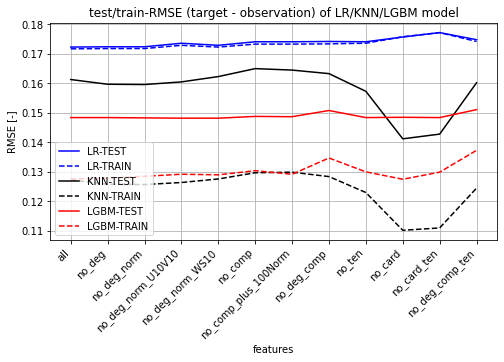

In [7]:
score = {'x':[], 'LGBM_test':[], 'LGBM_train':[], 'LR_test':[], 'LR_train':[], 'KNN_test':[], 'KNN_train':[]}

for key in feature_dict.keys():

    score['x'].append(key)
    score['LGBM_train'].append(results[key]['LGBM_train']['TOTAL'])
    score['LGBM_test'].append(results[key]['LGBM_test']['TOTAL'])
    score['LR_train'].append(results[key]['LR_train']['TOTAL'])
    score['LR_test'].append(results[key]['LR_test']['TOTAL'])
    score['KNN_train'].append(results[key]['KNN_train']['TOTAL'])
    score['KNN_test'].append(results[key]['KNN_test']['TOTAL'])

plt.figure(figsize=(8,4))

plt.plot(score['x'], score['LR_test'], 'b')
plt.plot(score['x'], score['LR_train'], linestyle='--', color='b')

plt.plot(score['x'], score['KNN_test'], 'k')
plt.plot(score['x'], score['KNN_train'], linestyle='--', color='k')

plt.plot(score['x'], score['LGBM_test'], 'r')
plt.plot(score['x'], score['LGBM_train'], linestyle='--', color='r')

plt.xticks(rotation=45, ha='right')
plt.ylabel('RMSE [-]')
plt.xlabel('features')
plt.legend(['LR-TEST','LR-TRAIN','KNN-TEST','KNN-TRAIN','LGBM-TEST','LGBM-TRAIN'],loc='lower left')
plt.title('test/train-RMSE (target - observation) of LR/KNN/LGBM model')
plt.grid()

In [24]:
lr = np.empty((11,1))
lgbm = np.empty((11,1)) #np.empty((11,1))
knn = np.empty((11,1)) #, np.empty((11,1))

for key in results.keys():
    lr = np.append(lr, np.array([value for value in results[key]['LR_test'].values()]).reshape(-1,1), axis=1)
    lgbm = np.append(lgbm, np.array([value for value in results[key]['LGBM_test'].values()]).reshape(-1,1), axis=1)
    knn = np.append(knn, np.array([value for value in results[key]['KNN_test'].values()]).reshape(-1,1), axis=1)

lr_max = np.max(lr[:,1:],axis=1)
lr_min = np.min(lr[:,1:],axis=1)

knn_max = np.max(knn[:,1:],axis=1)
knn_min = np.min(knn[:,1:],axis=1)

lgbm_max = np.max(lgbm[:,1:],axis=1)
lgbm_min = np.min(lgbm[:,1:],axis=1)

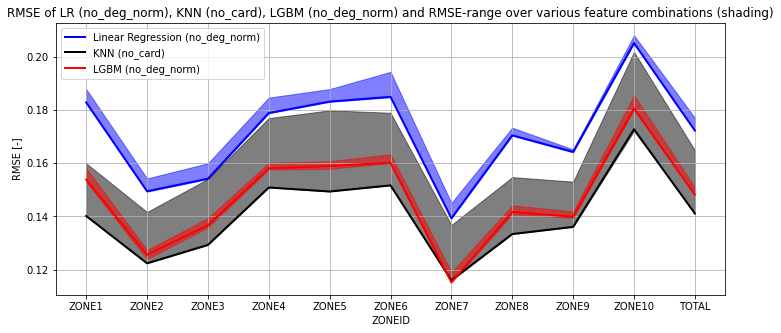

In [40]:

plt.figure(figsize=(12,5))

x = list(results['no_deg_norm']['LR_test'].keys())
y_LR = np.array(list(results['no_deg_norm']['LR_test'].values()))
y_KNN = np.array(list(results['no_card']['KNN_test'].values()))
y_LGBM = np.array(list(results['no_deg_norm']['LGBM_test'].values()))

plt.plot(x, y_LR, 'b', linewidth=2)
plt.plot(x, y_KNN, 'k', linewidth=2)
plt.plot(x, y_LGBM, 'r', linewidth=2)
plt.grid()

plt.fill_between(x, lr_min, lr_max, alpha=.5, color='b')
plt.fill_between(x, knn_min, knn_max, alpha=.5, color='k')
plt.fill_between(x, lgbm_min, lgbm_max, alpha=.5, color='r')

plt.xlabel('ZONEID')
plt.ylabel('RMSE [-]')
plt.legend(['Linear Regression (no_deg_norm)', 'KNN (no_card)', 'LGBM (no_deg_norm)'])
plt.title('RMSE of LR (no_deg_norm), KNN (no_card), LGBM (no_deg_norm) and RMSE-range over various feature combinations (shading)');
